# JVM: Java virtual machine
---

系统软件无法通用是一个常见的问题。但Java 代码可以在 Linux 运行，也可以在 Windows 运行，我们并没有生成多份不同的代码。Java 语言是如何做到的呢？

Java 之所以可以“Write Once Run Anywhere”，一是因为 JVM 针对各种操作系统、平台都进行了定制，二是因为无论在什么平台，都需要先编译生成固定格式的字节码（.class 文件）才能运行(供 JVM 使用)。

> The javac program takes source files as input and produces bytecode files.         
If you have a source file `homework/Main.java` you would produce the corresponding bytecode file by running javac `homework/Main.java`. This would then produce a file `homework/Main.class`.

## 1 字节码结构
----

之所以被称之为字节码，是因为字节码文件由十六进制值组成，而 JVM 以两个十六进制值为一组，即以字节为单位进行读取。

编译后生成 ByteCodeDemo.class 文件，打开后是一堆十六进制数，JVM 对于字节码是有规范要求的，那么看似杂乱的十六进制符合什么结构呢？JVM 规范要求每一个字节码文件都要由下面部分按照固定的顺序组成：

```java
ClassFile {
    u4             magic;
    u2             minor_version;
    u2             major_version;
    u2             constant_pool_count;
    cp_info        constant_pool[constant_pool_count-1];
    u2             access_flags;
    u2             this_class;
    u2             super_class;
    u2             interfaces_count;
    u2             interfaces[interfaces_count];
    u2             fields_count;
    field_info     fields[fields_count];
    u2             methods_count;
    method_info    methods[methods_count];
    u2             attributes_count;
    attribute_info attributes[attributes_count];
}
```


### 1.1 魔数（Magic Number）

每个 .class 文件的头 4 个字节称为 魔数（magic number），它的唯一作用是确定这个文件是否为一个能被虚拟机接收的 .class 文件。魔数的固定值为：0xCAFEBABE。

### 1.2 版本号（Version）

版本号为魔数之后的 4 个字节，前两个字节表示次版本号（Minor Version），后两个字节表示主版本号（Major Version）。

举例来说，如果版本号为：“00 00 00 34”。那么，次版本号转化为十进制为 0，主版本号转化为十进制为 52，在 Oracle 官网中查询序号 52 对应的主版本号为 1.8，所以编译该文件的 Java 版本号为 1.8.0。

### 1.3 常量池（Constant Pool）

紧接着主版本号之后的字节为常量池, 常量池主要存放两类常量：

+ 字面量 - 如文本字符串、声明为 final 的常量值. 
+ 符号引用 - 类和接口的全限定名, 字段的名称和描述符, 方法的名称和描述符. 

常量池整体上分为两部分：常量池计数器以及常量池数据区. 

**常量池计数器**（constant_pool_count）- 由于常量的数量不固定，所以需要先放置两个字节来表示常量池容量计数值。图 2 中示例代码的字节码前 10 个字节如下图所示，将十六进制的 24 转化为十进制值为 36，排除掉下标“0”，也就是说，这个类文件中共有 35 个常量。

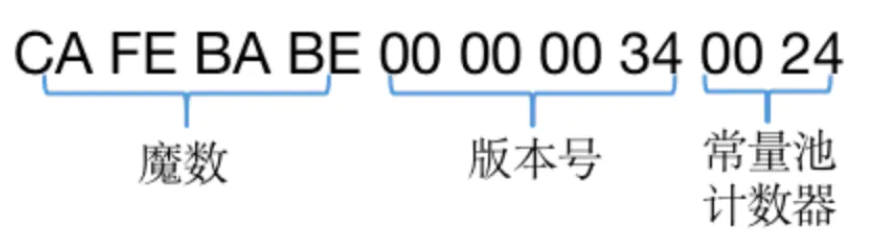


> The content of the constant pool consists of symbolic references generated by the compiler. These references are names of variables, methods, interfaces, and classes referenced from the code. The JVM uses them to link the code with other classes it depends on.


**拓展：**

Let's understand the structure of a constant pool using a simple Java class:

```java
class Application {
    public static void main(String[] args) {
        System.out.println("hello, Shaowen");
    }
}
```

To view the constant pool's content, we need to first compile the file and then run the command:

```bash
javap -v name.class
```

The above command will yield:

![5.png](attachment:5.png)

`#n` indicates the references to the constant pool. `#18` is a symbolic reference to the “Hello World” String, #19 is System.out, and #20 is a println. Similarly, #8 highlights that the return type of method is void and #21 is a fully qualified class name.

It is important to note that the constant pool table starts from index 1. The index value 0 is regarded as an invalid index.


### 1.4 访问标志

紧接着的 2 个字节代表访问标志，这个标志用于识别一些类或者接口的访问信息，描述该 Class 是类还是接口，以及是否被 public、abstract、final 等修饰符修饰。

### 1.5 当前类名

访问标志后的 2 个字节，描述的是当前类的全限定名。这两个字节保存的值为常量池中的索引值(`#n`)，根据索引值就能在常量池中找到这个类的全限定名。

### 1.6 父类名称

当前类名后的 2 个字节，描述父类的全限定名，同上，保存的也是常量池中的索引值。

### 1.7 接口信息

父类名称后为 2 字节的接口计数器，描述了该类或父类实现的接口数量。紧接着的 n 个字节是所有接口名称的字符串常量的索引值。

### 1.8 字段表

字段表用于描述类和接口中声明的变量，包含类级别的变量以及实例变量，但是不包含方法内部声明的局部变量。字段表也分为两部分，第一部分为两个字节，描述字段个数；第二部分是每个字段的详细信息 fields_info。

字段表结构如下图所示：

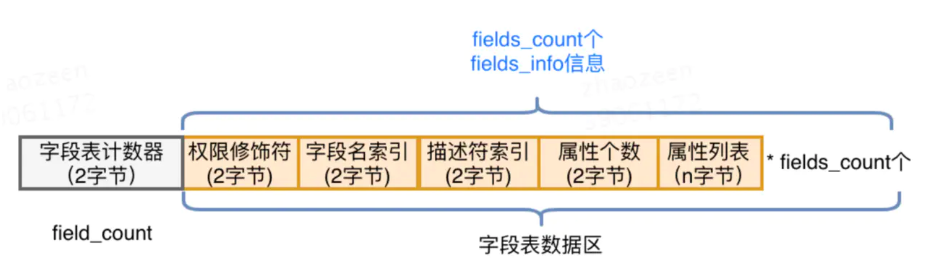

图 2 中字节码的字段表为例，如下图所示。其中字段的访问标志查图 9，0002 对应为 Private。通过索引下标在图 8 中常量池分别得到字段名为“a”，描述符为“I”（代表 int）。综上，就可以唯一确定出一个类中声明的变量 private int a。

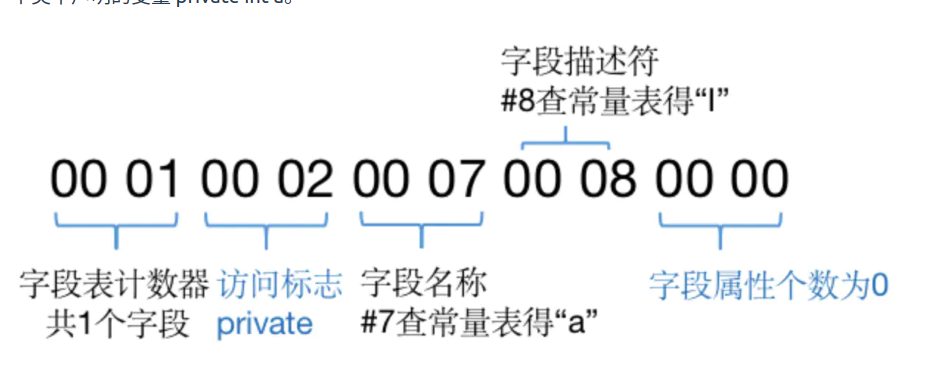



### 1.9 方法表

字段表结束后为方法表，方法表也是由两部分组成，第一部分为两个字节描述方法的个数；第二部分为每个方法的详细信息。方法的详细信息较为复杂，包括方法的访问标志、方法名、方法的描述符以及方法的属性；



## 2 Java 编译器
---

无论什么语言写的代码，其到最后都是通过机器码运行的，无一例外，对于 Java 语言来说，其从源代码到机器码，这中间到底发生了什么呢？ 

编译器可以分为：

+ 前端编译器（SUN的javac(jdk中的小程序)）


+ JIT 编译器（HotSpot VM的C1, C2编译期）


+ AOT编译器（GNU Compiler for Java=GCJ）


> ps：     
Hotspot 是最流行的 JVM。    
Java 虚拟机的主要组件，包括类加载器、运行时数据区和执行引擎。      


而Java为了实现“一次编译，处处运行”的特性，把编译的过程分成两部分，首先它会先由javac编译成通用的中间形式——字节码，然后再由解释器逐条将字节码解释为机器码来执行。

为了优化Java的性能 ，JVM在解释器之外引入了即时（Just In Time）编译器：当程序运行时，解释器首先发挥作用，代码可以直接执行。随着时间推移，即时编译器(JIT)逐渐发挥作用，把越来越多的代码编译优化成本地代码，来获取更高的执行效率。解释器这时可以作为编译运行的降级手段，在一些不可靠的编译优化出现问题时，再切换回解释执行，保证程序可以正常运行。

### 2.1 Java的执行过程

Java的执行过程整体可以分为两个部分，第一步由javac将源码编译成字节码，在这个过程中会进行词法分析、语法分析、语义分析，编译原理中这部分的编译称为前端编译。接下来无需编译直接逐条将字节码解释执行，在解释执行的过程中，虚拟机同时对程序运行的信息进行收集，在这些信息的基础上，编译器会逐渐发挥作用，它会进行后端编译——把字节码编译成机器码，但不是所有的代码都会被编译，只有被JVM认定为的热点代码，才可能被编译。

怎么样才会被认为是热点代码呢？JVM中会设置一个阈值，当方法或者代码块的在一定时间内的调用次数超过这个阈值时就会被编译，存入codeCache中。当下次执行时，再遇到这段代码，就会从codeCache中读取机器码，直接执行，以此来提升程序运行的性能。整体的执行过程大致如下图所示：

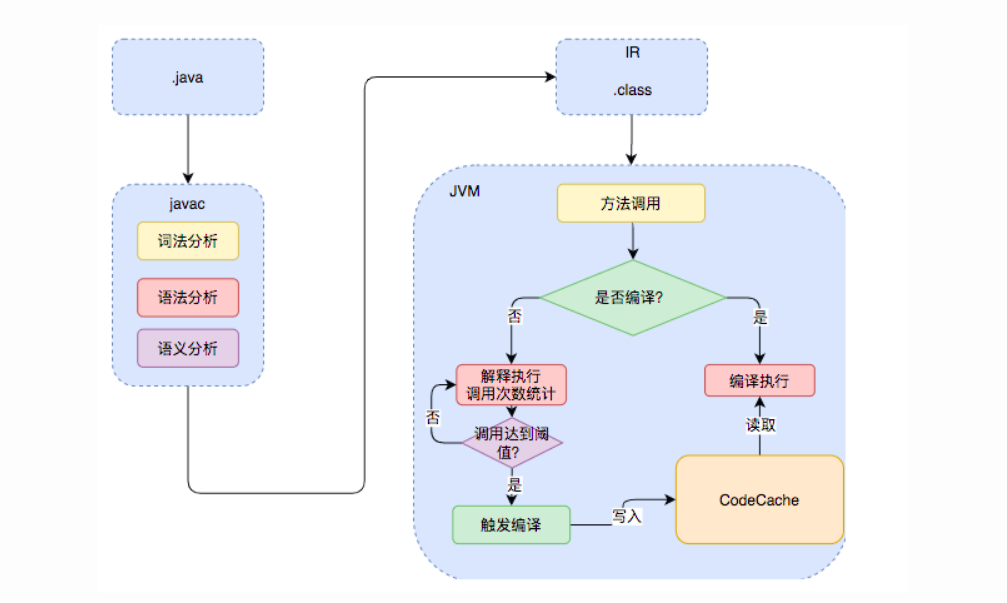

### 2.2 前端编译器：源代码到字节码

我们运行 javac 命令的过程，其实就是 javac 编译器解析 Java 源代码，并生成字节码文件的过程。说白了，其实就是使用 javac 编译器把 Java 语言规范转化为字节码语言规范。javac 编译器的处理过程可以分为下面四个阶段：

第一个阶段：词法、语法分析。在这个阶段，javac 编译器会对源代码的字符进行一次扫描，最终生成一个抽象的语法树。简单地说，在这个阶段 javac 编译器会搞懂我们的代码到底想要干嘛。就像我们分析一个句子一样，我们会对句子划分主谓宾，弄清楚这个句子要表达的意思一样。

第二个阶段：填充符号表。我们知道类之间是会互相引用的，但在编译阶段，我们无法确定其具体的地址，所以我们会使用一个符号来替代。在这个阶段做的就是类似的事情，即对抽象的类或接口进行符号填充。等到类加载阶段，javac 编译器会将符号替换成具体的内存地址。

第三个阶段：注解处理。我们知道 Java 是支持注解的，因此在这个阶段会对注解进行分析，根据注解的作用将其还原成具体的指令集。

第四个阶段：分析与字节码生成。到了这个阶段，javac 编译器便会根据上面几个阶段分析出来的结果，进行字节码的生成，最终输出为 class 文件。

我们一般称 javac 编译器为前端编译器，因为其发生在整个编译的前期。常见的前端编译器有 Sun 的 javac，Eclipse JDT 的增量式编译器（ECJ）。


### 2.3 JIT 编译器：从字节码到机器码

当源代码转化为字节码之后，其实要运行程序，有两种选择。一种是使用 Java 解释器解释执行字节码，另一种则是使用 JIT 编译器将字节码转化为本地机器代码。

这两种方式的区别在于，前者启动速度快但运行速度慢，而后者启动速度慢但运行速度快。至于为什么会这样，其原因很简单。因为解释器不需要像 JIT 编译器一样，将所有字节码都转化为机器码，自然就少去了优化的时间。而当 JIT 编译器完成第一次编译后，其会将字节码对应的机器码保存下来，下次可以直接使用。而我们知道，机器码的运行效率肯定是高于 Java 解释器的。所以在实际情况中，为了运行速度以及效率，我们通常采用两者相结合的方式进行 Java 代码的编译执行。

在 HotSpot 虚拟机内置了两个即时编译器，分别称为 Client Compiler 和Server Compiler。这两种不同的编译器衍生出两种不同的编译模式，我们分别称之为：C1 编译模式，C2 编译模式。

注意：现在许多人习惯上将 Client Compiler 称为 C1 编译器，将 Server Compiler 称为 C2 编译器，但在 Oracle 官方文档中将其描述为 compiler mode（编译模式）。所以说 C1 编译器、C2 编译器只是我们自己的习惯性称呼，并不是官方的说法。这点需要特别注意。



#### 2.3.1 C1 编译模式和 C2 编译模式有什么区别呢？

C1 编译模式会将字节码编译为本地代码，进行简单、可靠的优化，如有必要将加入性能监控的逻辑。而 C2 编译模式，也是将字节码编译为本地代码，但是会启用一些编译耗时较长的优化，甚至会根据性能监控信息进行一些不可靠的激进优化。

简单地说 C1 编译模式做的优化相对比较保守，其编译速度相比 C2 较快。而 C2 编译模式会做一些激进的优化，并且会根据性能监控做针对性优化，所以其编译质量相对较好，但是耗时更长。

#### 2.3.2 到底应该选择 C1 编译模式还是 C2 编译模式呢？

实际上对于 HotSpot 虚拟机来说，其一共有三种运行模式可选，分别是：

+ 混合模式（Mixed Mode） 。即 C1 和 C2 两种模式混合起来使用，这是默认的运行模式。如果你想单独使用 C1 模式或 C2 模式，使用 `-client `或 `server` 打开即可。


+ 解释模式（Interpreted Mode）。即所有代码都解释执行，使用 `-Xint` 参数可以打开这个模式。


+ 编译模式（Compiled Mode）。 此模式优先采用编译，但是无法编译时也会解释执行，使用 `-Xcomp` 打开这种模式。


在命令行中输入 java -version 可以看到，我机器上的虚拟机使用 Mixed Mode 运行模式:

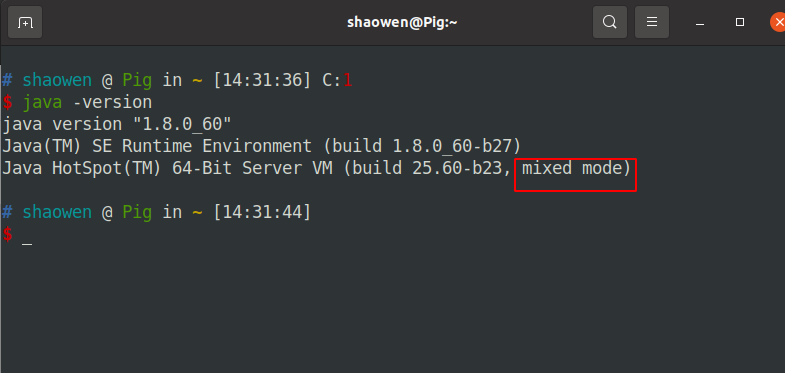

到这里，我们了解了从 Java 源代码到字节码，再从字节码到机器码的全过程。本来到这里就应该结束了，但在我们 Java 中还有一个 AOT 编译器，它能直接将源代码转化为机器码。

### 2.4 AOT 编译器：源代码到机器码

AOT 编译器的基本思想是：在程序执行前生成 Java 方法的本地代码，以便在程序运行时直接使用本地代码。

但是 Java 语言本身的动态特性带来了额外的复杂性，影响了 Java 程序静态编译代码的质量。例如 Java 语言中的动态类加载，因为 AOT 是在程序运行前编译的，所以无法获知这一信息，所以会导致一些问题的产生。类似的问题还有很多，这里就不一一举例了。

总的来说，AOT 编译器从编译质量上来看，肯定比不上 JIT 编译器。其存在的目的在于避免 JIT 编译器的运行时性能消耗或内存消耗，或者避免解释程序的早期性能开销。

在运行速度上来说，AOT 编译器编译出来的代码比 JIT 编译出来的慢，但是比解释执行的快。而编译时间上，AOT 也是一个始终的速度。所以说，AOT 编译器的存在是 JVM 牺牲质量换取性能的一种策略。就如 JVM 其运行模式中选择 Mixed 混合模式一样，使用 C1 编译模式只进行简单的优化，而 C2 编译模式则进行较为激进的优化。充分利用两种模式的优点，从而达到最优的运行效率。

## 3 JVM内存模型（运行时数据区）
---

看到这里，我相信大家对于一个 Java 源文件是如何变成字节码文件，以及字节码文件的含义已经非常清楚了。那么接下来就是让 Java 虚拟机运行字节码文件，从而得出我们最终想要的结果了。在这个过程中，Java 虚拟机会加载字节码文件，将其存入 Java 虚拟机的内存空间中，之后进行一系列的初始化动作，最后运行程序得出结果。

那么字节码数据在 Java 虚拟机内存中是如何存放的 ？Java 虚拟机在为类实例或成员变量分配内存是如何分配的 ？要解答上面这些问题，我们首先需要了解一下 Java 虚拟机的内存结构。

其实 Java 虚拟机的内存结构并不是官方的说法，在《Java 虚拟机规范》中用的是「运行时数据区」这个术语。



JVM 在执行 Java 程序的过程中会把它所管理的内存划分为若干个不同的数据区域。这些区域都有各自的用途，以及创建和销毁的时间，有的区域随着虚拟机进程的启动而存在，有些区域则依赖用户线程的启动和结束而建立和销毁。

根据《Java 虚拟机规范》中的说法，Java 虚拟机的内存结构可以分为公有和私有两部分。公有指的是所有线程都共享的部分，指的是 Java 堆、方法区、常量池。私有指的是每个线程的私有数据，包括：PC寄存器、Java 虚拟机栈、本地方法栈。

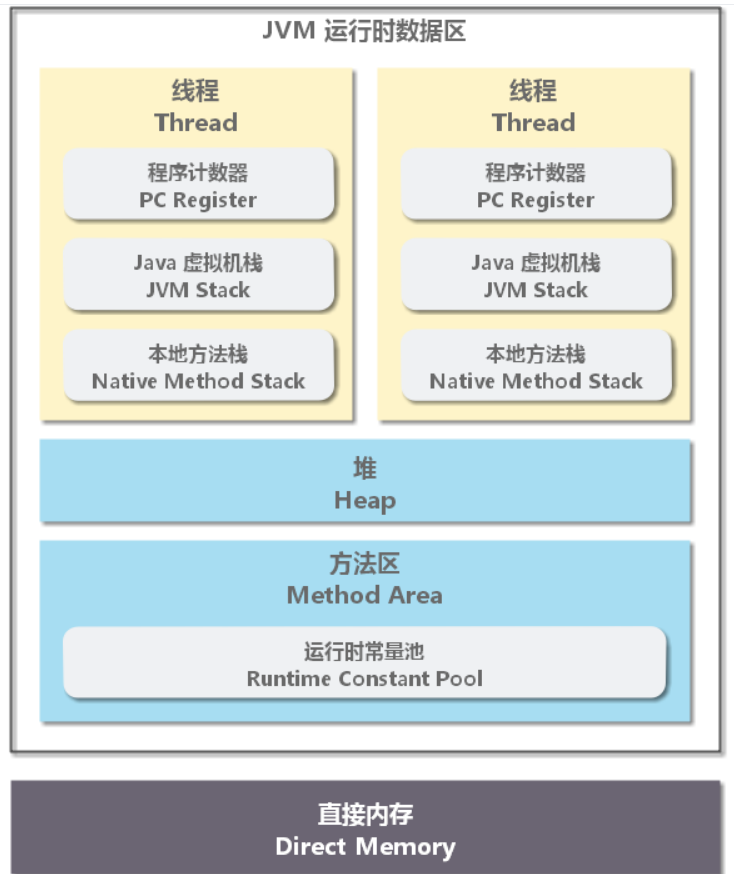

### 3.1. 程序计数器

`程序计数器（Program Counter Register）` 是一块较小的内存空间(线程私有)，它可以看做是**当前线程所执行的字节码的行号指示器** 。例如，分支、循环、跳转、异常、线程恢复等都依赖于计数器。

当执行的线程数量超过 CPU 数量时，线程之间会根据时间片轮询争夺 CPU 资源。如果一个线程的时间片用完了，或者是其它原因导致这个线程的 CPU 资源被提前抢夺，那么这个退出的线程就需要单独的一个程序计数器，来记录下一条运行的指令，从而在线程切换后能恢复到正确的执行位置。各条线程间的计数器互不影响，独立存储，我们称这类内存区域为 “线程私有” 的内存。

+ 如果线程正在执行的是一个 Java 方法，这个计数器记录的是正在执行的虚拟机字节码指令的地址；


+ 如果正在执行的是 Native 方法，这个计数器值则为空（Undefined）

>  注意：此内存区域是唯一一个在 JVM 中没有规定任何 OutOfMemoryError 情况的区域



### 3.2. Java 虚拟机栈

`Java 虚拟机栈（Java Virtual Machine Stacks）` 也是线程私有的，它的生命周期与线程相同。

每个 Java 方法在执行的同时都会创建一个栈帧（Stack Frame）用于存储 局部变量表、操作数栈、常量池引用 等信息。每一个方法从调用直至执行完成的过程，就对应着一个栈帧在 Java 虚拟机栈中入栈和出栈的过程。

+ 局部变量表 - 32 位变量槽，存放了编译期可知的各种基本数据类型、对象引用、ReturnAddress 类型。


+ 操作数栈 - 基于栈的执行引擎，虚拟机把操作数栈作为它的工作区，大多数指令都要从这里弹出数据、执行运算，然后把结果压回操作数栈。


+ 动态链接 - 每个栈帧都包含一个指向运行时常量池（方法区的一部分）中该栈帧所属方法的引用。持有这个引用是为了支持方法调用过程中的动态连接。Class 文件的常量池中有大量的符号引用，字节码中的方法调用指令就以常量池中指向方法的符号引用为参数。这些符号引用一部分会在类加载阶段或第一次使用的时候转化为直接引用，这种转化称为静态解析。另一部分将在每一次的运行期间转化为直接应用，这部分称为动态链接。


+ 方法出口 - 返回方法被调用的位置，恢复上层方法的局部变量和操作数栈，如果无返回值，则把它压入调用者的操作数栈。

>
🔔 注意：    
该区域可能抛出以下异常：    
如果线程请求的栈深度超过最大值，就会抛出 StackOverflowError 异常；    
如果虚拟机栈进行动态扩展时，无法申请到足够内存，就会抛出 OutOfMemoryError 异常。      
💡 提示：     
可以通过 -Xss 这个虚拟机参数来指定一个程序的 Java 虚拟机栈内存大小：    
```bash
java -Xss=512M HackTheJava
```

### 3.3. 本地方法栈

`本地方法栈（Native Method Stack）` 与虚拟机栈的作用相似。

二者的区别在于：虚拟机栈为 Java 方法服务；本地方法栈为 Native 方法服务。本地方法并不是用 Java 实现的，而是由 C 语言实现的。

> 🔔 注意：本地方法栈也会抛出 StackOverflowError 异常和 OutOfMemoryError 异常。

### 3.4. Java 堆

`Java 堆（Java Heap）` 的作用就是存放对象实例，几乎所有的对象实例都是在这里分配内存。

Java 堆是垃圾收集的主要区域（因此也被叫做"GC 堆"）。现代的垃圾收集器基本都是采用分代收集算法，该算法的思想是针对不同的对象采取不同的垃圾回收算法。因此虚拟机把 Java 堆分成以下三块：

1. 新生代（Young Generation）
    + Eden - Eden 和 Survivor 的比例为 8:1
    + From Survivor
    + To Survivor
    
    
2. 老年代（Old Generation）


3. 永久代（Permanent Generation）


当一个对象被创建时，它首先进入新生代，之后有可能被转移到老年代中。新生代存放着大量的生命很短的对象，因此新生代在三个区域中垃圾回收的频率最高。
 
> 🔔 注意：Java 堆不需要连续内存，并且可以动态扩展其内存，扩展失败会抛出 OutOfMemoryError 异常。        
💡 提示：可以通过 -Xms 和 -Xmx 两个虚拟机参数来指定一个程序的 Java 堆内存大小，第一个参数设置初始值，第二个参数设置最大值。     
```bash
java -Xms=1M -Xmx=2M HackTheJava
```


### 3.5. 方法区

`方法区（Method Area）`也被称为永久代。方法区用于存放已被加载的类信息、常量、静态变量、即时编译器编译后的代码等数据。

对这块区域进行垃圾回收的主要目标是对常量池的回收和对类的卸载，但是一般比较难实现。


### 3.6. 运行时常量池

`运行时常量池（Runtime Constant Pool）` 是方法区的一部分，Class 文件中除了有类的版本、字段、方法、接口等描述信息，还有一项信息是常量池（Constant Pool Table），用于存放编译器生成的各种字面量和符号引用，这部分内容会在类加载后被放入这个区域。

+ 字面量 - 文本字符串、声明为 final 的常量值等。


+ 符号引用 - 类和接口的完全限定名（Fully Qualified Name）、字段的名称和描述符（Descriptor）、方法的名称和描述符。


除了在编译期生成的常量，还允许动态生成，例如 String 类的 intern()。这部分常量也会被放入运行时常量池。

> 🔔 注意：当常量池无法再申请到内存时会抛出 OutOfMemoryError 异常。


### 3.7. 直接内存

直接内存（Direct Memory）并不是虚拟机运行时数据区的一部分，也不是 JVM 规范中定义的内存区域。



## JVM 运行原理
---

```java
public class JVMCase {

	// 常量
	public final static String MAN_SEX_TYPE = "man";

	// 静态变量
	public static String WOMAN_SEX_TYPE = "woman";

	public static void main(String[] args) {

		Student stu = new Student();
		stu.setName("nick");
		stu.setSexType(MAN_SEX_TYPE);
		stu.setAge(20);

		JVMCase jvmcase = new JVMCase();

		// 调用静态方法
		print(stu);
		// 调用非静态方法
		jvmcase.sayHello(stu);
	}


	// 常规静态方法
	public static void print(Student stu) {
		System.out.println("name: " + stu.getName() + "; sex:" + stu.getSexType() + "; age:" + stu.getAge());
	}


	// 非静态方法
	public void sayHello(Student stu) {
		System.out.println(stu.getName() + "say: hello");
	}
}

class Student{
	String name;
	String sexType;
	int age;

	public String getName() {
		return name;
	}
	public void setName(String name) {
		this.name = name;
	}

	public String getSexType() {
		return sexType;
	}
	public void setSexType(String sexType) {
		this.sexType = sexType;
	}
	public int getAge() {
		return age;
	}
	public void setAge(int age) {
		this.age = age;
	}
}
```

运行以上代码时，JVM 处理过程如下：

（1）JVM 向操作系统申请内存，JVM 第一步就是通过配置参数或者默认配置参数向操作系统申请内存空间，根据内存大小找到具体的内存分配表，然后把内存段的起始地址和终止地址分配给 JVM，接下来 JVM 就进行内部分配。


（2）JVM 获得内存空间后，会根据配置参数分配堆、栈以及方法区的内存大小。


（3）class 文件加载、验证、准备以及解析，其中准备阶段会为类的静态变量分配内存，初始化为系统的初始值。

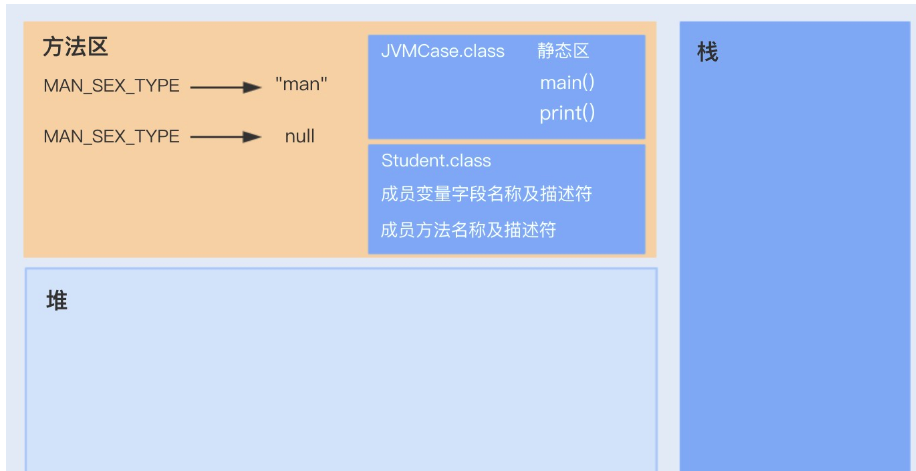


（4）完成上一个步骤后，将会进行最后一个初始化阶段。在这个阶段中，JVM 首先会执行构造器 `<clinit>` 方法，编译器会在 `.java` 文件被编译成 `.class` 文件时，收集所有类的初始化代码，包括静态变量赋值语句、静态代码块、静态方法，收集在一起成为 `<clinit>()` 方法。

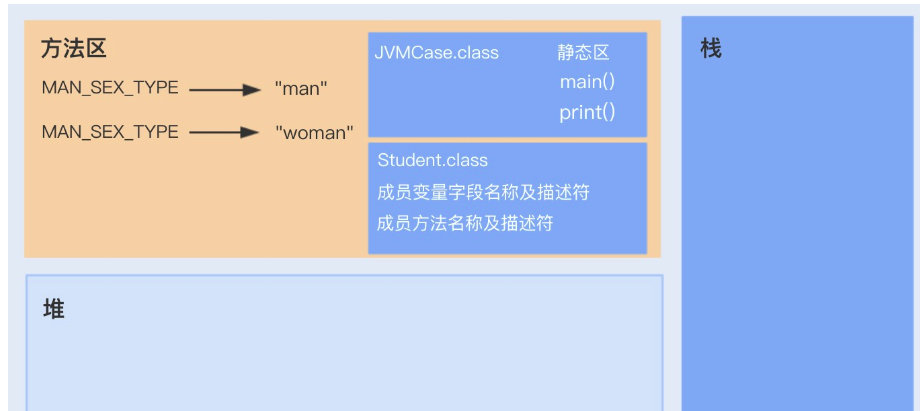


（5）执行方法。启动 main 线程，执行 main 方法，开始执行第一行代码。此时堆内存中会创建一个 student 对象，对象引用 student 就存放在栈中。

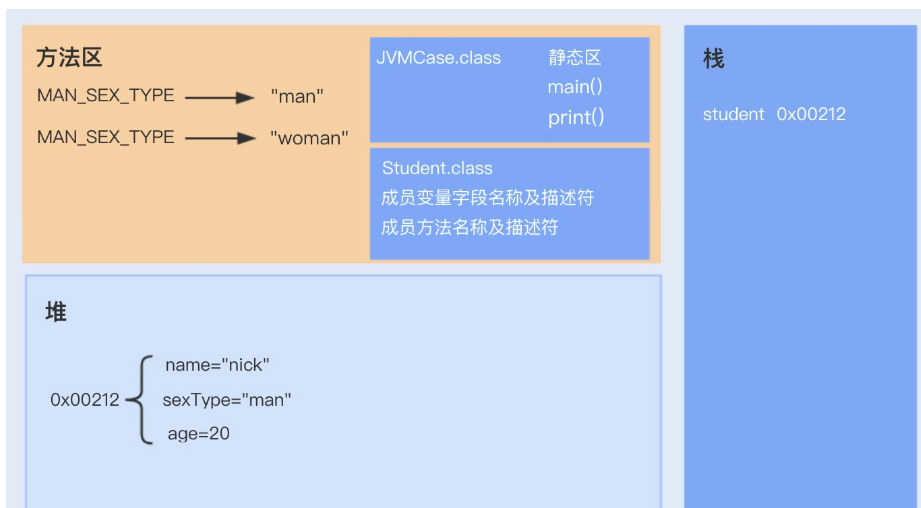


（6）此时再次创建一个 JVMCase 对象，调用 sayHello 非静态方法，sayHello 方法属于对象 JVMCase，此时 sayHello 方法入栈，并通过栈中的 student 引用调用堆中的 Student 对象；之后，调用静态方法 print，print 静态方法属于 JVMCase 类，是从静态方法中获取，之后放入到栈中，也是通过 student 引用调用堆中的 student 对象。

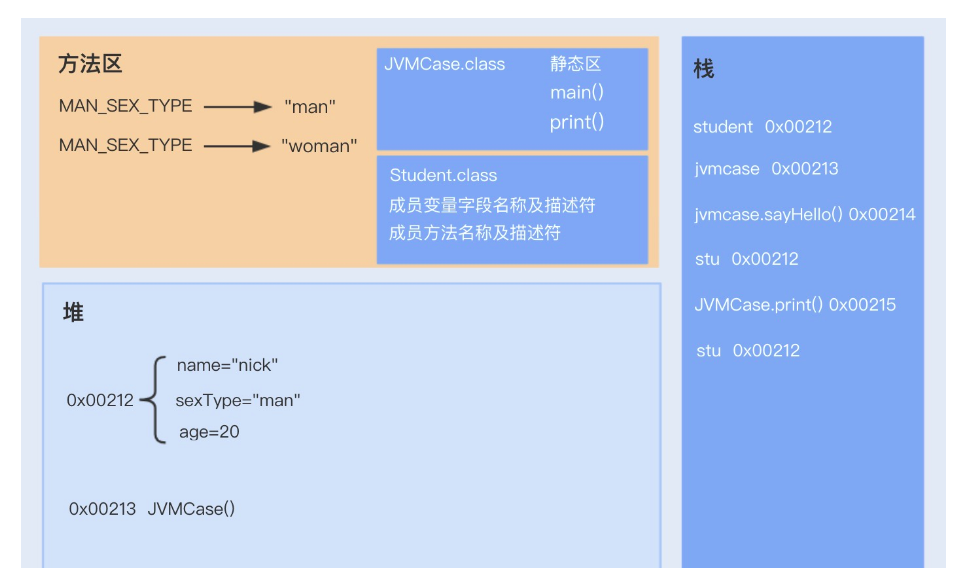


## 4 JVM 类加载过程
---

当编译器将 Java 源码编译为字节码之后，Class 文件需要加载到虚拟机中之后才能运行和使用，那么虚拟机是如何加载这些 Class 文件呢？

> 系统加载 Class 类型的文件主要三步：加载->连接->初始化。`连接`过程又可分为三步：验证->准备->解析。

### 4.1. 类的生命周期

一个类的完整生命周期如下：

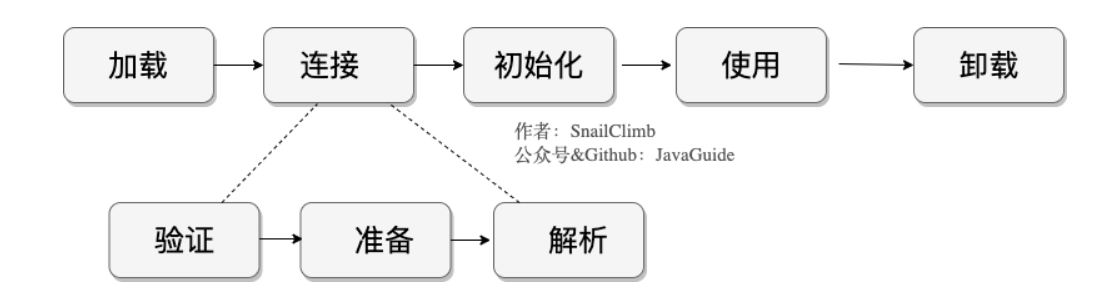


### 4.2.  类加载过程

> 类加载过程是指加载、验证、准备、解析和初始化这 5 个阶段。

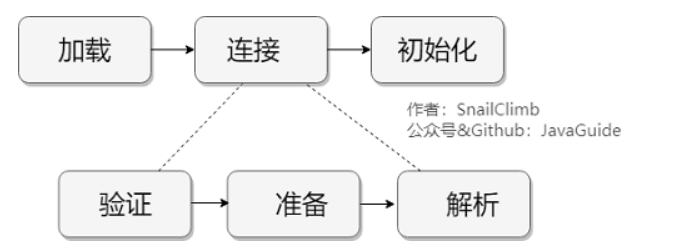


#### 4.2.1. 加载

类加载过程的第一步，主要完成下面 3 件事情：

+ 通过全类名获取定义此类的二进制字节流


+ 将字节流所代表的静态存储结构转换为方法区的运行时数据结构


+ 在内存中生成一个代表该类的 Class 对象，作为方法区这些数据的访问入口


虚拟机规范上面这 3 点并不具体，因此是非常灵活的。比如："通过全类名获取定义此类的二进制字节流" 并没有指明具体从哪里获取、怎样获取。比如：比较常见的就是从 ZIP 包中读取（日后出现的 JAR、EAR、WAR 格式的基础）、其他文件生成（典型应用就是 JSP）等等。

一个非数组类的加载阶段（加载阶段获取类的二进制字节流的动作）是可控性最强的阶段，这一步我们可以去完成还可以自定义类加载器去控制字节流的获取方式（重写一个类加载器的 loadClass() 方法）。数组类型不通过类加载器创建，它由 Java 虚拟机直接创建。

类加载器、双亲委派模型也是非常重要的知识点，这部分内容会在后面的文章中单独介绍到。

加载阶段和连接阶段的部分内容是交叉进行的，加载阶段尚未结束，连接阶段可能就已经开始了。



#### 4.2.2. 验证

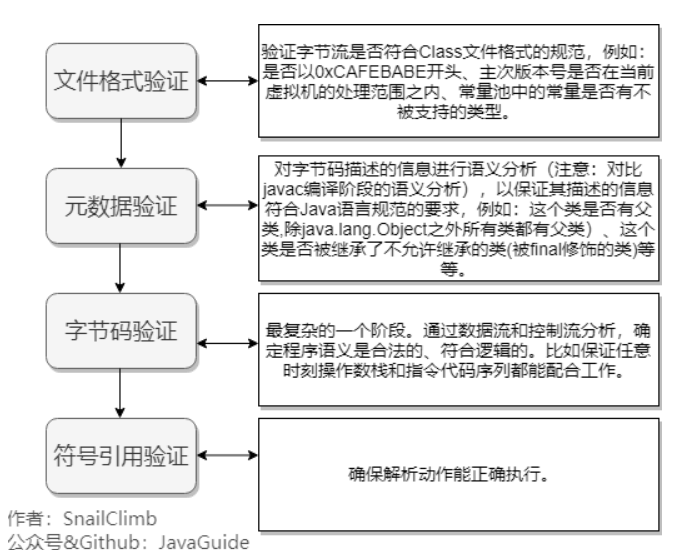

#### 4.2.3. 准备

准备阶段是正式为类变量分配内存并设置类变量初始值的阶段，这些内存都将在方法区中分配。对于该阶段有以下几点需要注意：

+ 这时候进行内存分配的仅包括类变量（ Class Variables ，即静态变量，被 static 关键字修饰的变量，只与类相关，因此被称为类变量），而不包括实例变量。实例变量会在对象实例化时随着对象一块分配在 Java 堆中。


+ 从概念上讲，类变量所使用的内存都应当在 方法区 中进行分配。不过有一点需要注意的是：JDK 7 之前，HotSpot 使用永久代来实现方法区的时候，实现是完全符合这种逻辑概念的。 而在 JDK 7 及之后，HotSpot 已经把原本放在永久代的字符串常量池、静态变量等移动到堆中，这个时候类变量则会随着 Class 对象一起存放在 Java 堆中。


+ 这里所设置的初始值"通常情况"下是数据类型默认的零值（如 0、0L、null、false 等），比如我们定义了`public static int value=111` ，那么 value 变量在准备阶段的初始值就是 0 而不是 111（初始化阶段才会赋值）。特殊情况：比如给 value 变量加上了 final 关键字public `static final int value=111` ，那么准备阶段 value 的值就被赋值为 111。

#### 4.2.4. 解析

解析阶段是虚拟机将常量池内的符号引用替换为直接引用的过程。解析动作主要针对类或接口、字段、类方法、接口方法、方法类型、方法句柄和调用限定符 7 类符号引用进行。

符号引用就是一组符号来描述目标，可以是任何字面量。直接引用就是直接指向目标的指针、相对偏移量或一个间接定位到目标的句柄。在程序实际运行时，只有符号引用是不够的，举个例子：在程序执行方法时，系统需要明确知道这个方法所在的位置。Java 虚拟机为每个类都准备了一张方法表来存放类中所有的方法。当需要调用一个类的方法的时候，只要知道这个方法在方法表中的偏移量就可以直接调用该方法了。通过解析操作符号引用就可以直接转变为目标方法在类中方法表的位置，从而使得方法可以被调用。

综上，解析阶段是虚拟机将常量池内的符号引用替换为直接引用的过程，也就是得到类或者字段、方法在内存中的指针或者偏移量。



#### 4.2.5. 初始化

初始化阶段是执行初始化方法 `<clinit> ()`方法的过程，是类加载的最后一步，这一步 JVM 才开始真正执行类中定义的 Java 程序代码(字节码)。

> 说明： <clinit> ()方法是编译之后自动生成的。
    

对于`<clinit> ()` 方法的调用，虚拟机会自己确保其在多线程环境中的安全性。因为` <clinit> ()` 方法是带锁线程安全，所以在多线程环境下进行类初始化的话可能会引起多个进程阻塞，并且这种阻塞很难被发现。
    
对于初始化阶段，虚拟机严格规范了有且只有 5 种情况下，必须对类进行初始化(只有主动去使用类才会初始化类)：
    

1. 当遇到 new 、 getstatic、putstatic 或 invokestatic 这 4 条直接码指令时，比如 new 一个类，读取一个静态字段(未被 final 修饰)、或调用一个类的静态方法时。
    + 当 jvm 执行 new 指令时会初始化类。即当程序创建一个类的实例对象。
    + 当 jvm 执行 getstatic 指令时会初始化类。即程序访问类的静态变量(不是静态常量，常量会被加载到运行时常量池)。
    + 当 jvm 执行 putstatic 指令时会初始化类。即程序给类的静态变量赋值。
    + 当 jvm 执行 invokestatic 指令时会初始化类。即程序调用类的静态方法。
    
    
2. 使用 java.lang.reflect 包的方法对类进行反射调用时如 Class.forname("..."), newInstance() 等等。如果类没初始化，需要触发其初始化。


3. 初始化一个类，如果其父类还未初始化，则先触发该父类的初始化。


4. 当虚拟机启动时，用户需要定义一个要执行的主类 (包含 main 方法的那个类)，虚拟机会先初始化这个类。


5. MethodHandle 和 VarHandle 可以看作是轻量级的反射调用机制，而要想使用这 2 个调用， 就必须先使用 findStaticVarHandle 来初始化要调用的类。



#### 4.2.6. 卸载

卸载类即该类的 Class 对象被 GC。

卸载类需要满足 3 个要求:

+ 该类的所有的实例对象都已被 GC，也就是说堆不存在该类的实例对象


+ 该类没有在其他任何地方被引用


+ 该类的类加载器的实例已被 GC

所以，在 JVM 生命周期内，由 jvm 自带的类加载器加载的类是不会被卸载的。但是由我们自定义的类加载器加载的类是可能被卸载的。

只要想通一点就好了，jdk 自带的 BootstrapClassLoader, ExtClassLoader, AppClassLoader 负责加载 jdk 提供的类，所以它们(类加载器的实例)肯定不会被回收。而我们自定义的类加载器的实例是可以被回收的，所以使用我们自定义加载器加载的类是可以被卸载掉的。